In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.0 igraph==0.11.5 pynndescent==0.5.12


In [2]:
nr = sc.read_h5ad('./h5ad/filter/V1_NR_L23_filter.h5ad')
dr = sc.read_h5ad('./h5ad/filter/V1_DR_L23_filter.h5ad')

In [3]:
pc_gene = pd.read_csv('V1_L23_Lasso_PC1rank.xls',sep='\t')

In [4]:
nr_ptime = pd.read_csv('./ptime/HVG_N_L23_root.txt',sep='\t') #NR ptime results
dr_ptime = pd.read_csv('./ptime/HVG_D_L23_root.txt',sep='\t')

In [5]:
nr_exp=pd.DataFrame(nr.X.todense(),index=nr.obs.index,columns=nr.var.index)
nr_exp = nr_exp.reset_index()
nr_exp['cell_id_match'] = nr_exp['index'].str[:12]
df_ptime_nr = pd.merge(nr_exp, nr_ptime, left_on='cell_id_match', right_on='cell_id', how='left')

# Delete the unnecessary columns and reset the index
df_ptime_nr = df_ptime_nr.drop(columns=['cell_id_match', 'cell_id']).set_index('index')
df_ptime_nr = df_ptime_nr.dropna()
df_ptime_nr_sorted = df_ptime_nr.sort_values(by='velocity_pseudotime', ascending=True)


dr_exp=pd.DataFrame(dr.X.todense(),index=dr.obs.index,columns=dr.var.index)
dr_exp = dr_exp.reset_index()
dr_exp['cell_id_match'] = dr_exp['index'].str[:12]
df_ptime_dr = pd.merge(dr_exp, dr_ptime, left_on='cell_id_match', right_on='cell_id', how='left')
# 
df_ptime_dr = df_ptime_dr.drop(columns=['cell_id_match', 'cell_id']).set_index('index')
df_ptime_dr = df_ptime_dr.dropna()
df_ptime_dr_sorted = df_ptime_dr.sort_values(by='velocity_pseudotime', ascending=True)

del df_ptime_nr_sorted['velocity_pseudotime']
df_ptime_nr_sorted['index'] = range(df_ptime_nr_sorted.shape[0])
df_ptime_nr_sorted['index_bin'] = pd.cut(df_ptime_nr_sorted['index'], bins=np.arange(0, 3292 + 3292/100, 3292/100))
bin_means_nr = df_ptime_nr_sorted.groupby('index_bin').mean()
bin_means_nr['index'] = range(bin_means_nr.shape[0])

del df_ptime_dr_sorted['velocity_pseudotime']
df_ptime_dr_sorted['index'] = range(df_ptime_dr_sorted.shape[0])
df_ptime_dr_sorted['index_bin'] = pd.cut(df_ptime_dr_sorted['index'], bins=np.arange(0, 3098 + 3098/100, 3098/100))
bin_means_dr = df_ptime_dr_sorted.groupby('index_bin').mean()
bin_means_dr['index'] = range(bin_means_dr.shape[0])

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_78737/3956134441.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_nr = df_ptime_nr_sorted.groupby('index_bin').mean()
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_78737/3956134441.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_dr = df_ptime_dr_sorted.groupby('index_bin').mean()


In [6]:
import seaborn as sns
sns.set_theme(style="ticks")

In [7]:
nr_pc_gene = pc_gene[['Gene','nr_pc_lasso','logFC']]
dr_pc_gene = pc_gene[['Gene','dr_pc_lasso','logFC']]

In [7]:
bin_means_nr_ = bin_means_nr
bin_means_nr_.index = list(bin_means_nr_['index'])
del bin_means_nr_['index']
bin_means_nr_T = bin_means_nr_.T

bin_means_dr_ = bin_means_dr
bin_means_dr_.index = list(bin_means_dr_['index'])
del bin_means_dr_['index']
bin_means_dr_T = bin_means_dr_.T

slope_ =[]
for i in range(bin_means_dr_T.shape[0]):
    x = np.array(bin_means_dr.index)
    y = np.array(bin_means_dr[bin_means_dr_T.index[i]])
    valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x = x[valid_indices]
    y = y[valid_indices]
    slope,intercept = np.polyfit(x, y,1)
    slope_.append(slope)
bin_means_dr_T['slope'] = slope_

slope_ =[]
for i in range(bin_means_nr_T.shape[0]):
    x = np.array(bin_means_nr.index)
    y = np.array(bin_means_nr[bin_means_nr_T.index[i]])
    valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x = x[valid_indices]
    y = y[valid_indices]
    slope,intercept = np.polyfit(x, y,1)
    slope_.append(slope)
bin_means_nr_T['slope'] = slope_

In [9]:
nr_pc_gene = pc_gene[['Gene','nr_pc_lasso','logFC']]
dr_pc_gene = pc_gene[['Gene','dr_pc_lasso','logFC']]
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_dr_T.index)
slope_df['slope']= list(bin_means_dr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(dr_pc_gene.shape[0]):
    if dr_pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][dr_pc_gene['Gene'][i]])
    else:
        slope.append('No')
dr_pc_gene['slope'] = slope
dr_pc_gene = dr_pc_gene[dr_pc_gene['slope'] != 'No']
dr_pc_gene['slope_abs'] = dr_pc_gene['slope'].abs()

dr_pc_gene_filter = dr_pc_gene[dr_pc_gene['dr_pc_lasso'] != 4000]
###
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_nr_T.index)
slope_df['slope']= list(bin_means_nr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(nr_pc_gene.shape[0]):
    if nr_pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][nr_pc_gene['Gene'][i]])
    else:
        slope.append('No')
nr_pc_gene['slope'] = slope
nr_pc_gene = nr_pc_gene[nr_pc_gene['slope'] != 'No']
nr_pc_gene['slope_abs'] = nr_pc_gene['slope'].abs()

nr_pc_gene_filter = nr_pc_gene[nr_pc_gene['nr_pc_lasso'] != 4000]

nr_pc_gene_filter['Cond'] = 'NR'
dr_pc_gene_filter['Cond'] = 'DR'

nr_pc_gene_filter['Rank'] = nr_pc_gene_filter['nr_pc_lasso']
dr_pc_gene_filter['Rank'] = dr_pc_gene_filter['dr_pc_lasso']
del nr_pc_gene_filter['nr_pc_lasso']
del dr_pc_gene_filter['dr_pc_lasso']
df_merge_pc_gene = pd.concat([nr_pc_gene_filter, dr_pc_gene_filter])

df_merge_pc_gene['slope_abs'] = df_merge_pc_gene['slope_abs']*100

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_33575/694031600.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_pc_gene['slope'] = slope
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_33575/694031600.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nr_pc_gene['slope'] = slope
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_33575/694031600.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [10]:
df_merge_pc_gene

,Gene,logFC,slope,slope_abs,Cond,Rank
0,Sgcd,0.022139,0.002344,0.234417,NR,193
1,Gm12446,0.876353,-0.000099,0.009946,NR,1460
2,6530403H02Rik,0.722466,0.009046,0.904632,NR,19
3,St6galnac5,3.009043,0.000566,0.056573,NR,496
5,Arhgef28,0.801280,0.002778,0.277798,NR,135
...,...,...,...,...,...,...
1116,Mbp,-0.044123,-0.000678,0.067773,DR,160
1117,Syndig1,-5.279644,-0.006098,0.609835,DR,102
1118,Tmem175,-2.444544,0.000361,0.036050,DR,734
1119,E330018M18Rik,-0.106412,0.000268,0.026849,DR,613


In [16]:
bin_means_nr_T

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,slope
Xkr4,1.826031,1.952419,1.833146,1.659925,1.746494,1.690871,1.869405,1.879468,1.456633,1.536733,...,2.110210,2.563686,2.383887,2.361149,2.459313,2.361320,2.350578,2.597395,2.457923,0.004776
Gm1992,0.391483,0.515265,0.526025,0.533353,0.634244,0.493349,0.533738,0.467790,0.496728,0.501697,...,0.791211,0.799788,0.431848,0.889723,0.833858,1.042667,1.117831,0.826912,0.782685,0.002755
Gm19938,0.123333,0.030029,0.028257,0.074722,0.093138,0.094324,0.125730,0.267096,0.000000,0.236277,...,0.130737,0.232395,0.185636,0.275519,0.284031,0.153226,0.324023,0.180395,0.216191,0.000688
Rp1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000032
Mrpl15,0.072587,0.036310,0.000000,0.083633,0.000000,0.029401,0.081820,0.093578,0.043628,0.026504,...,0.062209,0.000000,0.188262,0.171635,0.000000,0.033215,0.038000,0.000000,0.071901,-0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933409K07Rik,0.072045,0.078166,0.000000,0.000000,0.038296,0.073247,0.106184,0.000000,0.000000,0.036111,...,0.080081,0.032627,0.000000,0.000000,0.000000,0.036742,0.000000,0.000000,0.000000,-0.000195
Gm10931,0.000000,0.040389,0.000000,0.074569,0.000000,0.000000,0.000000,0.042614,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000028
CT868723.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000022
CAAA01147332.1,0.028281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049172,0.000000,...,0.000000,0.000000,0.000000,0.028549,0.047339,0.000000,0.000000,0.000000,0.000000,-0.000006


In [11]:
df_NR = df_merge_pc_gene[df_merge_pc_gene['Cond'] == 'NR']
df_DR = df_merge_pc_gene[df_merge_pc_gene['Cond'] == 'DR']

In [13]:
df_NR['slope_abs'].min()


3.556173966522639e-05

In [14]:
df_NR['slope_abs'].max()

1.9550555649727914

In [15]:
df_NR_0 = df_NR[df_NR['slope_abs'] > 0.5]
df_NR_1 = df_NR[df_NR['slope_abs'] <= 0.5]
df_NR_1 = df_NR_1[df_NR_1['slope_abs'] > 0.1]
df_NR_2 = df_NR[(df_NR['slope_abs'] > 0.02) & (df_NR['slope_abs'] <= 0.1) ]
df_NR_3 = df_NR[df_NR['slope_abs'] <= 0.02]

df_DR_0 = df_DR[df_DR['slope_abs'] > 0.5]
df_DR_1 = df_DR[df_DR['slope_abs'] <= 0.5]
df_DR_1 = df_DR_1[df_DR_1['slope_abs'] > 0.1]
df_DR_2 = df_DR[(df_DR['slope_abs'] > 0.02) & (df_DR['slope_abs'] <= 0.1) ]
df_DR_3 = df_DR[df_DR['slope_abs'] <= 0.02]

拟合参数：a = 26.226735294170542, b = -1.9195695060552813


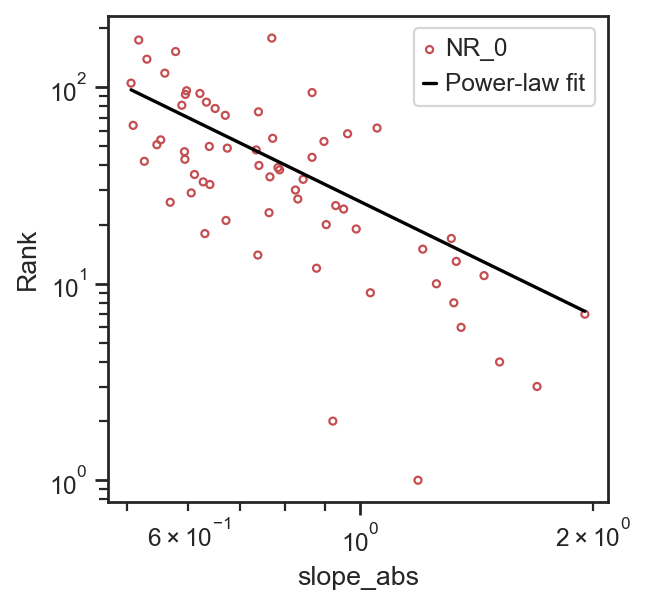

In [20]:
Rank = np.array(df_NR_0['Rank']+1)
slope_abs = np.array(df_NR_0['slope_abs'])
from scipy.optimize import curve_fit


# Define power-law functions
def power_law(x, a, b):
    return a * np.power(x, b)

# use curve_fit
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# Output the fitting parameters
print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='NR_0', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log') 
plt.yscale('log') 
plt.show()

拟合参数：a = 110.37844554635957, b = -0.6636710557942487


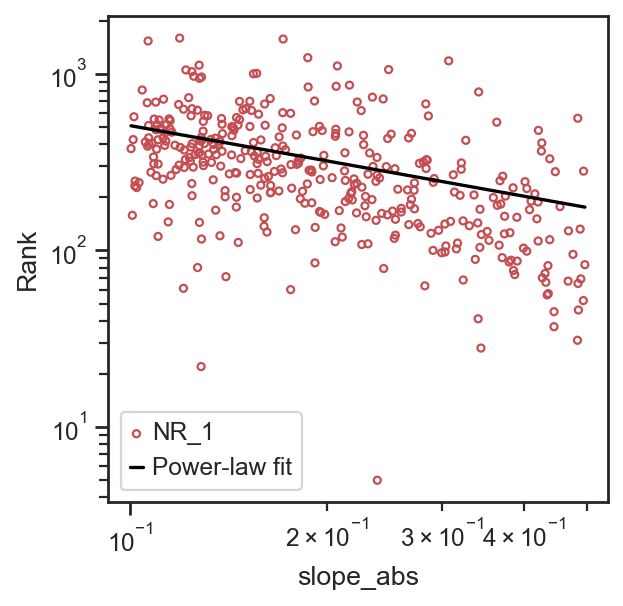

In [21]:
Rank = np.array(df_NR_1['Rank']+1)
slope_abs = np.array(df_NR_1['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='NR_1', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log') 
plt.yscale('log') 
plt.show()

拟合参数：a = 210.72766411054374, b = -0.37078453976277514


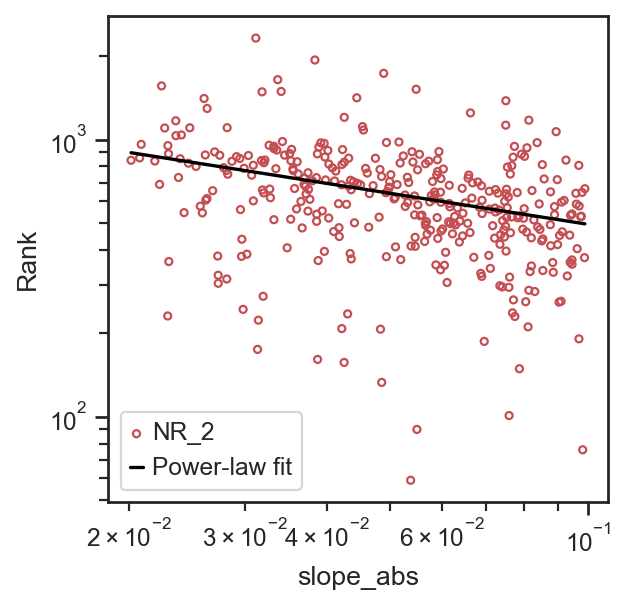

In [22]:
Rank = np.array(df_NR_2['Rank']+1)
slope_abs = np.array(df_NR_2['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='NR_2', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log') 
plt.yscale('log') 
plt.show()

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_24033/1961059537.py:8: RuntimeWarning: overflow encountered in power
  return a * np.power(x, b)


拟合参数：a = 768.5523952669517, b = -0.048479540468916685


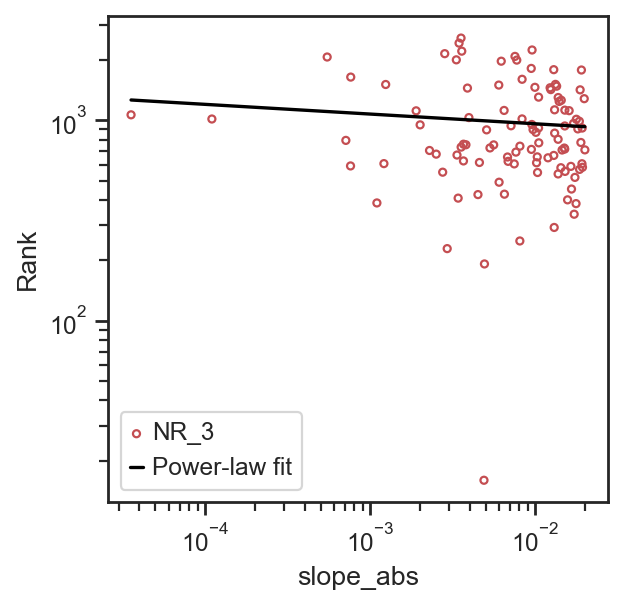

In [23]:
Rank = np.array(df_NR_3['Rank']+1)
slope_abs = np.array(df_NR_3['slope_abs'])
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params


print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='NR_3', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log') 
plt.yscale('log') 
plt.show()

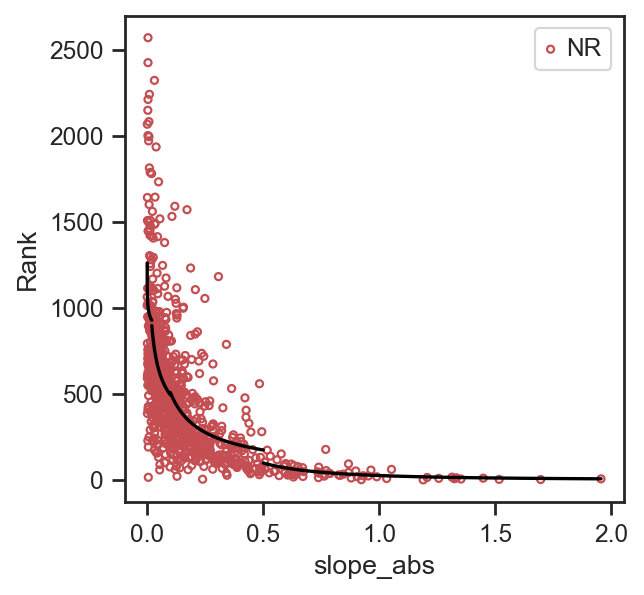

In [24]:
Rank = np.array(df_NR['Rank']+1)
slope_abs = np.array(df_NR['slope_abs'])

# fitting parameters
nr_0_a = 26.2267
nr_0_b = -1.9195
nr_1_a = 110.3784
nr_1_b = -0.6636
nr_2_a = 210.7276
nr_2_b = -0.3707
nr_3_a = 768.5523
nr_3_b = -0.0484


plt.scatter(slope_abs, Rank, label='NR', color='r', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(0.5, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.1, 0.5, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.02, 0.1, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'black')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'black')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'black')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'black')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()


plt.show()

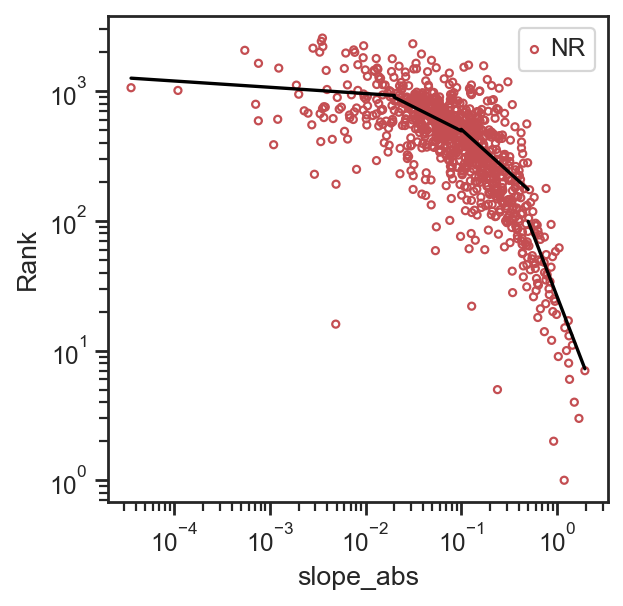

In [25]:

plt.scatter(slope_abs, Rank, label='NR', color='r', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(0.5, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.1, 0.5, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.02, 0.1, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'black')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'black')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'black')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'black')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.show()

In [26]:
NR_predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['NR_slpoe_abs'][i] >0.5:
        rank = 26.2267* np.power(pc_gene['NR_slpoe_abs'][i], -1.9195)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slpoe_abs'][i] >0.1:
        rank = 110.3784* np.power(pc_gene['NR_slpoe_abs'][i], -0.6636)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slpoe_abs'][i] >0.02:
        rank = 210.7276* np.power(pc_gene['NR_slpoe_abs'][i],-0.3707)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slpoe_abs'][i] <= 0.02:
        rank = 768.5523* np.power(pc_gene['NR_slpoe_abs'][i],-0.0484)
        NR_predicted_rank.append(rank)
pc_gene['NR_predicted_rank'] = NR_predicted_rank

拟合参数：a = 88.03557315698056, b = -2.22800877828416


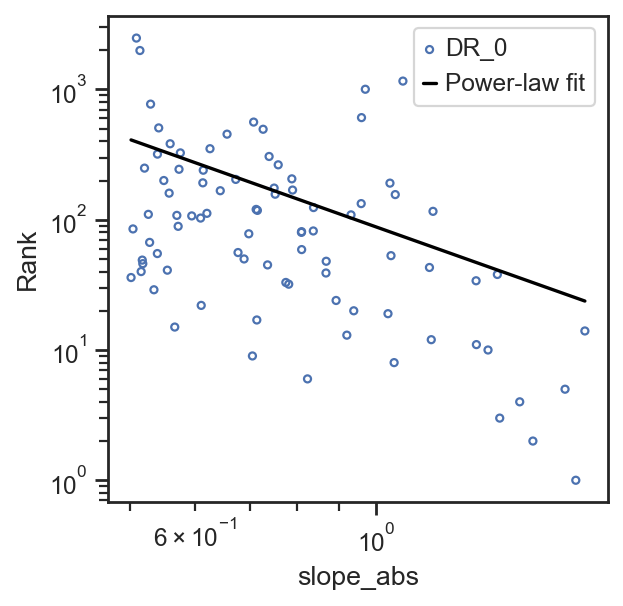

In [27]:
Rank = np.array(df_DR_0['Rank']+1)
slope_abs = np.array(df_DR_0['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params


print(f"拟合参数：a = {a}, b = {b}")


plt.scatter(slope_abs, Rank, label='DR_0', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

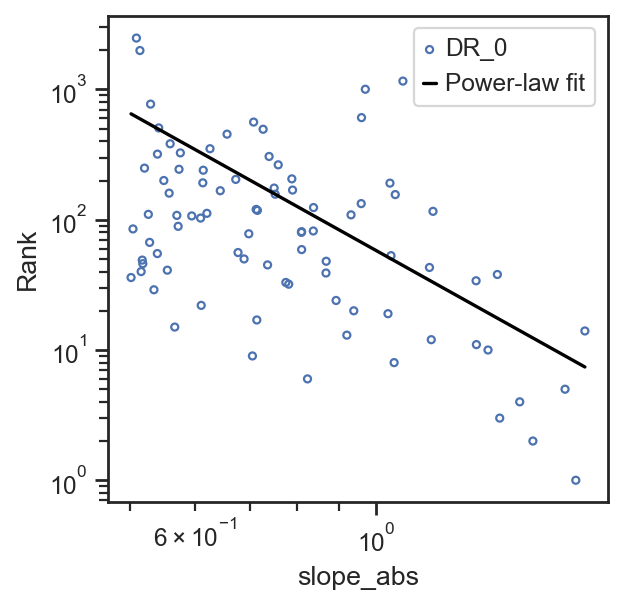

In [34]:

plt.scatter(slope_abs, Rank, label='DR_0', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, 58, -3.5)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

拟合参数：a = 179.42020920214287, b = -0.521159535037262


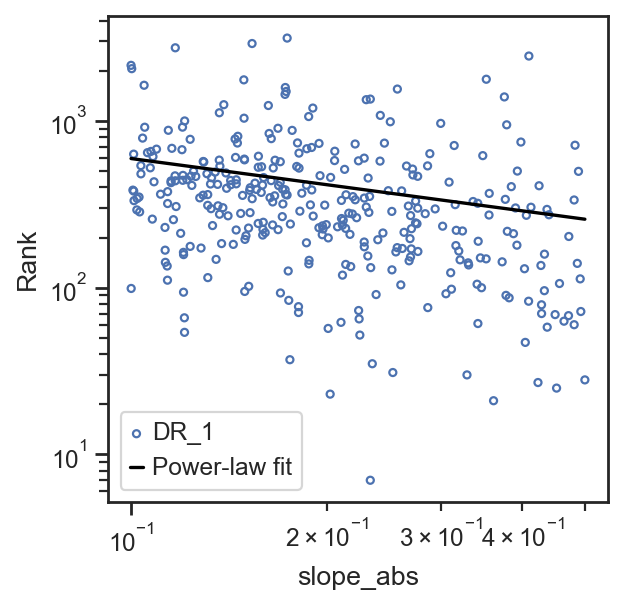

In [35]:
Rank = np.array(df_DR_1['Rank']+1)
slope_abs = np.array(df_DR_1['slope_abs'])
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params


print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='DR_1', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

拟合参数：a = 220.6410386072841, b = -0.37388715374820036


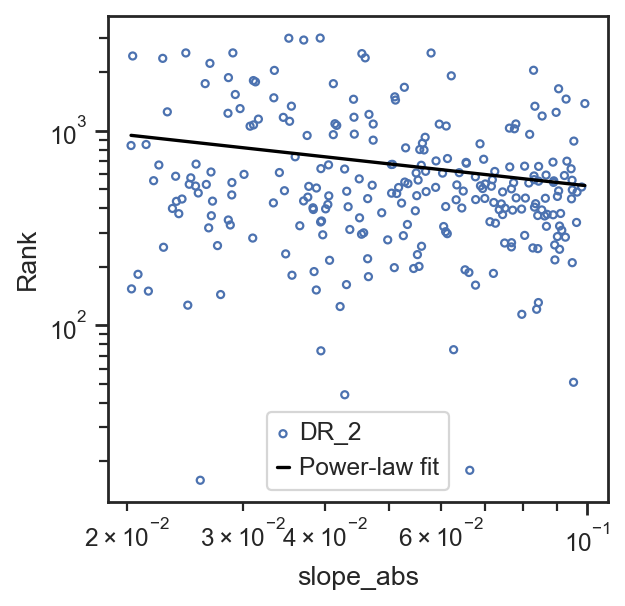

In [46]:
Rank = np.array(df_DR_2['Rank']+1)
slope_abs = np.array(df_DR_2['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='DR_2', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log') 
plt.yscale('log') 
plt.show()

拟合参数：a = 1284.7628306325107, b = 0.040411513728025365


/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_24033/1951665612.py:8: RuntimeWarning: overflow encountered in power
  return a * np.power(x, b)


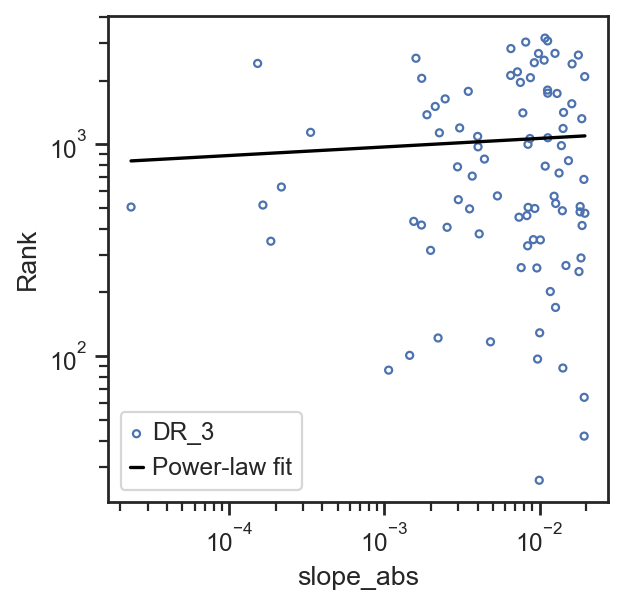

In [47]:
Rank = np.array(df_DR_3['Rank']+1)
slope_abs = np.array(df_DR_3['slope_abs'])
from scipy.optimize import curve_fit


# Define power-law functions
def power_law(x, a, b):
    return a * np.power(x, b)

# use curve_fit
params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

# Output the fitting parameters
print(f"拟合参数：a = {a}, b = {b}")


plt.scatter(slope_abs, Rank, label='DR_3', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log') 
plt.yscale('log') 
plt.show()

In [52]:
df_DR_3 = df_DR_3[df_DR_3['slope_abs'] > 0.006]

拟合参数：a = 73.41187496095272, b = -0.6121093007438589


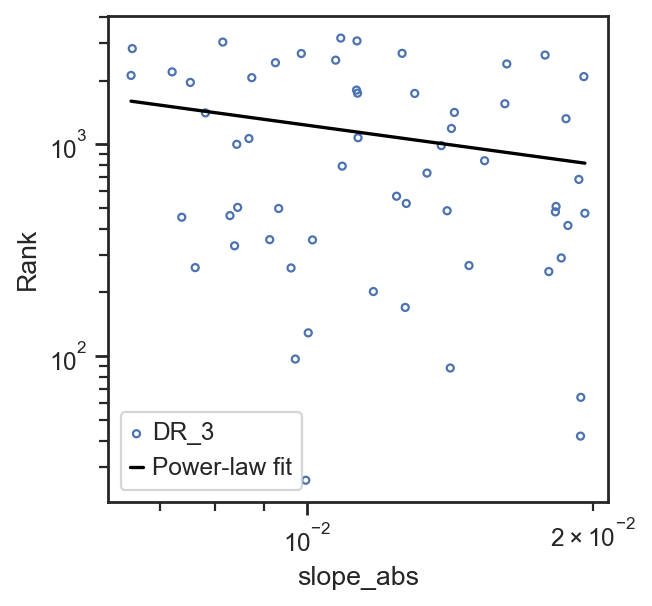

In [53]:
Rank = np.array(df_DR_3['Rank']+1)
slope_abs = np.array(df_DR_3['slope_abs'])
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * np.power(x, b)


params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params


print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='DR_3', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log') 
plt.yscale('log') 
plt.show()

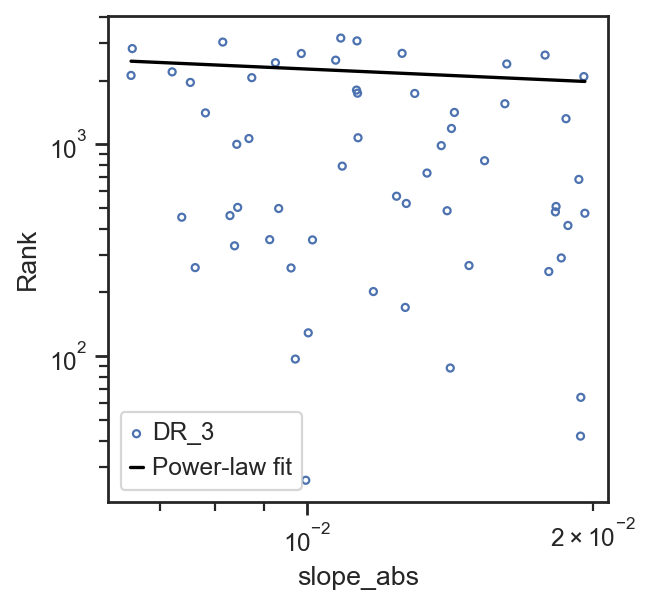

In [65]:

plt.scatter(slope_abs, Rank, label='DR_3', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, 901.763,  -0.2)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log') 
plt.yscale('log') 
plt.show()

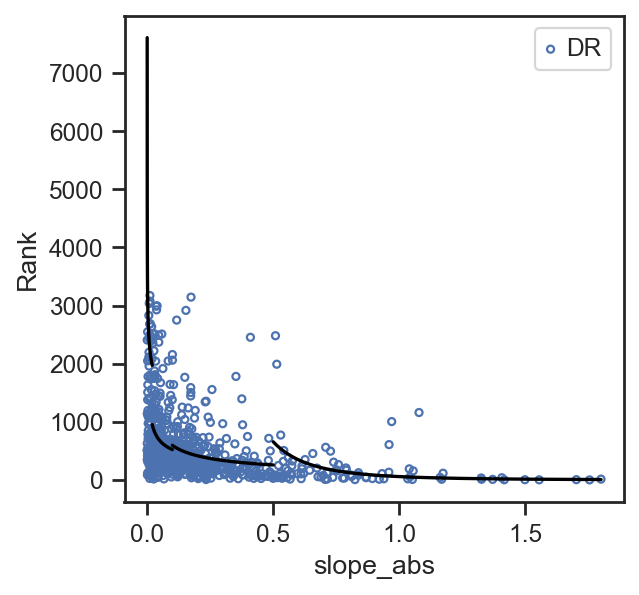

In [66]:
Rank = np.array(df_DR['Rank']+1)
slope_abs = np.array(df_DR['slope_abs'])

nr_0_a = 58
nr_0_b = -3.5
nr_1_a = 179.42020
nr_1_b = -0.5211
nr_2_a = 220.641
nr_2_b = -0.3738
nr_3_a = 901.763
nr_3_b = -0.2

plt.scatter(slope_abs, Rank, label='DR', color='b', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(0.5, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.1, 0.5, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.02, 0.1, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'black')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'black')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'black')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'black')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()

plt.show()

In [67]:
DR_predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['DR_slpoe_abs'][i] >0.5:
        rank = 58* np.power(pc_gene['DR_slpoe_abs'][i], -0.5211)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slpoe_abs'][i] >0.1:
        rank = 179.4202* np.power(pc_gene['DR_slpoe_abs'][i], -0.5211)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slpoe_abs'][i] >0.02:
        rank = 220.6410* np.power(pc_gene['DR_slpoe_abs'][i],-0.3738)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slpoe_abs'][i] <= 0.02:
        rank = 901.763* np.power(pc_gene['DR_slpoe_abs'][i],-0.2)
        DR_predicted_rank.append(rank)
pc_gene['DR_predicted_rank'] = DR_predicted_rank

In [70]:
pc_gene

,Gene,nr_pc_lasso,dr_pc_lasso,foldchange,logFC,NR_slpoe,NR_slpoe_abs,DR_slpoe,DR_slpoe_abs,NR_predicted_rank,DR_predicted_rank,subclassdeglogFC,DR_predicted_rank_final,NR_predicted_rank_final,foldchange_predicted,logFC_predicted
0,Sgcd,193,196,1.015464,0.022139,0.001174,0.234705,0.001333,0.266644,288.805179,357.287549,0.000000,196.000000,193.000000,1.015464,0.022139
1,Gm12446,1460,2681,1.835729,0.876353,-0.000049,0.009767,0.000048,0.009637,961.542225,2281.932476,-0.861033,2681.000000,1460.000000,1.835729,0.876353
2,6530403H02Rik,19,32,1.650000,0.722466,0.004522,0.904412,0.003871,0.774134,31.805213,66.277465,0.000000,32.000000,19.000000,1.650000,0.722466
3,St6galnac5,496,4000,8.050302,3.009043,0.000281,0.056151,0.000430,0.086016,612.820725,552.002005,0.000000,573.003442,496.000000,1.154937,0.207814
4,B230216N24Rik,4000,506,0.126718,-2.980303,0.001195,0.239093,0.002713,0.542602,285.277601,79.760869,0.848485,506.000000,285.462525,1.769865,0.823639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,Syndig1,4000,102,0.025744,-5.279644,-0.002338,0.467690,-0.003041,0.608249,182.767963,75.152469,-0.374234,102.000000,182.947802,0.559941,-0.836652
1118,Tmem175,4000,734,0.183704,-2.444544,-0.000529,0.105864,0.000170,0.034026,489.847756,780.719713,0.225611,734.000000,489.965661,1.497050,0.582122
1119,E330018M18Rik,660,613,0.928896,-0.106412,0.000182,0.036420,0.000126,0.025251,719.503720,872.802966,0.000000,613.000000,660.000000,0.928896,-0.106412
1120,Gm48091,4000,454,0.113722,-3.136422,-0.000076,0.015129,-0.001147,0.229492,941.393275,386.344863,-0.451238,454.000000,972.330193,0.467467,-1.097063


In [69]:
del pc_gene['Unnamed: 0']
del pc_gene['logFC_predicted_corrected']

In [71]:
predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['dr_pc_lasso'][i] != 4000:
        predicted_rank.append(pc_gene['dr_pc_lasso'][i])
    else:
        predicted_rank.append(pc_gene['DR_predicted_rank'][i])
pc_gene['DR_predicted_rank_final'] = predicted_rank

predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['nr_pc_lasso'][i] != 4000:
        predicted_rank.append(pc_gene['nr_pc_lasso'][i])
    else:
        predicted_rank.append(pc_gene['NR_predicted_rank'][i])
pc_gene['NR_predicted_rank_final'] = predicted_rank

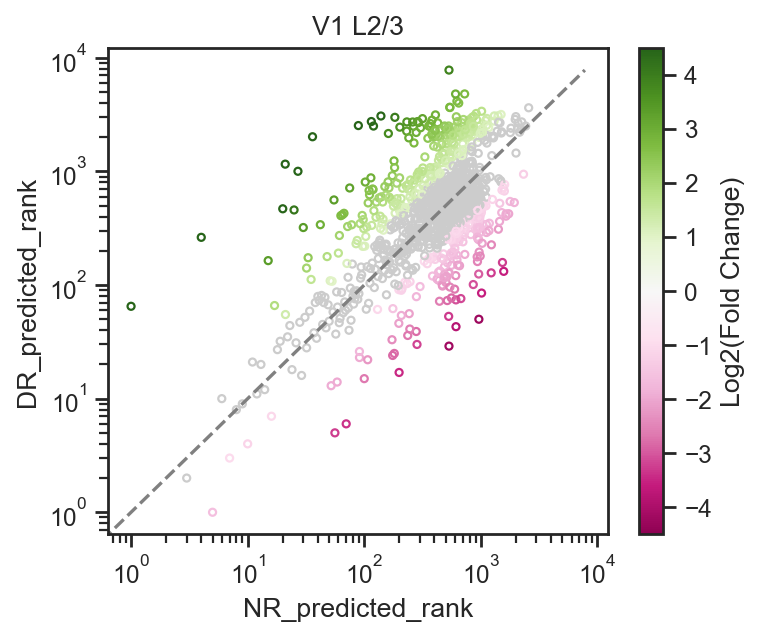

In [72]:
pc_gene['foldchange_predicted'] = (pc_gene['DR_predicted_rank_final']+1)/(pc_gene['NR_predicted_rank_final']+1)
pc_gene['logFC_predicted'] = np.log2(pc_gene['foldchange_predicted'])
# Create color mapping
color_condition = (pc_gene['logFC_predicted'] > -1) & (pc_gene['logFC_predicted'] < 1)


vmin, vmax = -4.5, 4.5
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Initialize the colors of all points and perform color mapping based on the logFC value
colors = plt.cm.PiYG(norm(pc_gene['logFC_predicted']))

# 将 gray_condition 和 color_condition 对应的点设置为灰色
#colors[gray_condition] = [0.5, 0.5, 0.5, 1.0]  # 灰色 (RGBA)
colors[color_condition] = [0.8, 0.8, 0.8, 1.0]  # 浅灰色 (RGBA)


fig, ax = plt.subplots(figsize=(5,4))


scatter = ax.scatter(x=pc_gene['NR_predicted_rank_final'], y=pc_gene['DR_predicted_rank_final'], 
                     s=10,marker='o', edgecolor=colors, facecolor='none')


sm = plt.cm.ScalarMappable(cmap="PiYG", norm=norm)
sm.set_array(pc_gene.loc[~color_condition, 'logFC_predicted'])  # 仅使用非灰色数据


cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Log2(Fold Change)')


limits = [0, max(pc_gene['NR_predicted_rank_final'].max(), pc_gene['DR_predicted_rank_final'].max())]
ax.plot(limits, limits, linestyle='--', color='gray')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('NR_predicted_rank')
ax.set_ylabel('DR_predicted_rank')
ax.set_title('V1 L2/3')


plt.show()

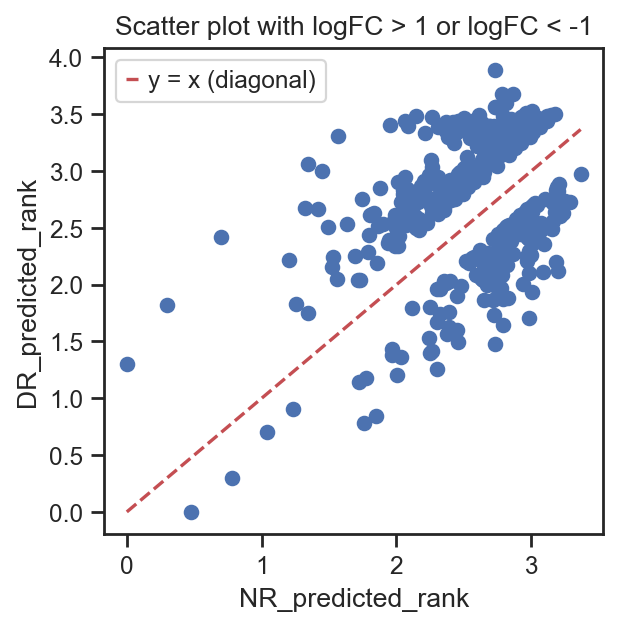

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_24033/4075930666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log Distance_to_Diagonal'] = log_distances


In [73]:

filtered_df = pc_gene[(pc_gene['logFC_predicted'] > 1) | (pc_gene['logFC_predicted'] < -1)]

x = np.log10(filtered_df['NR_predicted_rank_final']+1)
y = np.log10(filtered_df['DR_predicted_rank_final']+1)

plt.scatter(x, y, color='b')
plt.plot([min(x), max(x)], [min(x), max(x)], 'r--', label='y = x (diagonal)')
plt.xlabel('NR_predicted_rank')
plt.ylabel('DR_predicted_rank')
plt.title('Scatter plot with logFC > 1 or logFC < -1')
plt.legend()
plt.show()

log_distances = np.abs(y - x) / np.sqrt(2)

filtered_df['log Distance_to_Diagonal'] = log_distances

In [74]:
variance_of_distances = np.var(log_distances)
variance_of_distances

0.031703161221180234

In [75]:
filtered_df


,Gene,nr_pc_lasso,dr_pc_lasso,foldchange,logFC,NR_slpoe,NR_slpoe_abs,DR_slpoe,DR_slpoe_abs,NR_predicted_rank,DR_predicted_rank,subclassdeglogFC,DR_predicted_rank_final,NR_predicted_rank_final,foldchange_predicted,logFC_predicted,log Distance_to_Diagonal
7,Cdh6,51,109,2.115385,1.080920,-0.002483,0.496685,-0.002624,0.524802,175.616295,81.159346,0.000000,109.000000,51.000000,2.115385,1.080920,0.230085
8,Gm46367,4000,157,0.039490,-4.662364,-0.000445,0.088963,0.000604,0.120863,516.713745,539.621339,-0.359200,157.000000,516.713745,0.305188,-1.712230,0.364466
10,Adamtsl4,879,4000,4.546591,2.184785,-0.000129,0.025876,-0.000045,0.009095,816.696843,2308.511934,-1.321240,2308.511934,879.000000,2.624445,1.392013,0.296304
13,Sox5,264,4000,15.098113,3.916296,-0.000554,0.110743,0.000031,0.006101,475.418379,2500.390420,-0.416217,2500.390420,264.000000,9.439209,3.238666,0.689384
14,Kcnn2,967,195,0.202479,-2.304153,0.000629,0.125773,0.000268,0.053654,436.914792,658.508546,0.000000,195.000000,967.000000,0.202479,-2.304153,0.490463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,Hrh2,379,4000,10.528947,3.396289,-0.000140,0.028016,0.000069,0.013744,792.995016,2125.548905,-0.915837,2125.548905,379.000000,5.596181,2.484443,0.528839
1109,Hps4,862,2491,2.887601,1.529872,-0.000066,0.013176,0.000225,0.044925,947.710143,703.699187,0.482862,2491.000000,862.000000,2.887601,1.529872,0.325649
1112,Epha6,2,0,0.333333,-1.584963,0.008471,1.694256,0.008780,1.756086,9.532757,43.250902,0.713651,0.000000,2.000000,0.333333,-1.584963,0.337376
1120,Gm48091,4000,454,0.113722,-3.136422,-0.000076,0.015129,-0.001147,0.229492,941.393275,386.344863,-0.451238,454.000000,941.393275,0.482813,-1.050463,0.223602


In [77]:
filtered_df.index = range(0,455)

In [80]:
filtered_df

,Gene,nr_pc_lasso,dr_pc_lasso,foldchange,logFC,NR_slpoe,NR_slpoe_abs,DR_slpoe,DR_slpoe_abs,NR_predicted_rank,DR_predicted_rank,subclassdeglogFC,DR_predicted_rank_final,NR_predicted_rank_final,foldchange_predicted,logFC_predicted,log Distance_to_Diagonal,false_positive
0,Cdh6,51,109,2.115385,1.080920,-0.002483,0.496685,-0.002624,0.524802,175.616295,81.159346,0.000000,109.000000,51.000000,2.115385,1.080920,0.230085,Yes
1,Gm46367,4000,157,0.039490,-4.662364,-0.000445,0.088963,0.000604,0.120863,516.713745,539.621339,-0.359200,157.000000,516.713745,0.305188,-1.712230,0.364466,No
2,Adamtsl4,879,4000,4.546591,2.184785,-0.000129,0.025876,-0.000045,0.009095,816.696843,2308.511934,-1.321240,2308.511934,879.000000,2.624445,1.392013,0.296304,No
3,Sox5,264,4000,15.098113,3.916296,-0.000554,0.110743,0.000031,0.006101,475.418379,2500.390420,-0.416217,2500.390420,264.000000,9.439209,3.238666,0.689384,No
4,Kcnn2,967,195,0.202479,-2.304153,0.000629,0.125773,0.000268,0.053654,436.914792,658.508546,0.000000,195.000000,967.000000,0.202479,-2.304153,0.490463,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,Hrh2,379,4000,10.528947,3.396289,-0.000140,0.028016,0.000069,0.013744,792.995016,2125.548905,-0.915837,2125.548905,379.000000,5.596181,2.484443,0.528839,No
451,Hps4,862,2491,2.887601,1.529872,-0.000066,0.013176,0.000225,0.044925,947.710143,703.699187,0.482862,2491.000000,862.000000,2.887601,1.529872,0.325649,Yes
452,Epha6,2,0,0.333333,-1.584963,0.008471,1.694256,0.008780,1.756086,9.532757,43.250902,0.713651,0.000000,2.000000,0.333333,-1.584963,0.337376,No
453,Gm48091,4000,454,0.113722,-3.136422,-0.000076,0.015129,-0.001147,0.229492,941.393275,386.344863,-0.451238,454.000000,941.393275,0.482813,-1.050463,0.223602,No


In [88]:
fp = []
for i in range(filtered_df.shape[0]):
    test_slope = filtered_df['NR_slpoe_abs'][i] - filtered_df['DR_slpoe_abs'][i]
    test_rank = filtered_df['DR_predicted_rank_final'][i] - filtered_df['NR_predicted_rank_final'][i]
    test_slope_raw = filtered_df['NR_slpoe'][i] * filtered_df['DR_slpoe'][i]
    a = test_slope*test_rank
    if test_slope_raw < 0:
        fp.append('No')
    elif (filtered_df['subclassdeglogFC'][i] >0.4 or filtered_df['subclassdeglogFC'][i] < - 0.4):
        fp.append('No')
    elif test_slope_raw >= 0:
        if a <0:
            if test_rank < 0:
                if filtered_df['subclassdeglogFC'][i] <= 0:
                    fp.append('Yes')
                else:
                    fp.append('No')
            if test_rank > 0:
                if filtered_df['subclassdeglogFC'][i] >= 0:
                    fp.append('Yes')
                else:
                    fp.append('No')
        else:
            fp.append('No')
filtered_df['false_positive'] = fp

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_24033/1927891217.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['false_positive'] = fp


In [89]:
filtered_df['false_positive'].value_counts()

false_positive
No     428
Yes     27
Name: count, dtype: int64

In [90]:
filtered_df.to_csv('V1_L23_Lasso_PC1rank_predict_sig.xls',sep='\t')

In [91]:
filtered_df

,Gene,nr_pc_lasso,dr_pc_lasso,foldchange,logFC,NR_slpoe,NR_slpoe_abs,DR_slpoe,DR_slpoe_abs,NR_predicted_rank,DR_predicted_rank,subclassdeglogFC,DR_predicted_rank_final,NR_predicted_rank_final,foldchange_predicted,logFC_predicted,log Distance_to_Diagonal,false_positive
0,Cdh6,51,109,2.115385,1.080920,-0.002483,0.496685,-0.002624,0.524802,175.616295,81.159346,0.000000,109.000000,51.000000,2.115385,1.080920,0.230085,Yes
1,Gm46367,4000,157,0.039490,-4.662364,-0.000445,0.088963,0.000604,0.120863,516.713745,539.621339,-0.359200,157.000000,516.713745,0.305188,-1.712230,0.364466,No
2,Adamtsl4,879,4000,4.546591,2.184785,-0.000129,0.025876,-0.000045,0.009095,816.696843,2308.511934,-1.321240,2308.511934,879.000000,2.624445,1.392013,0.296304,No
3,Sox5,264,4000,15.098113,3.916296,-0.000554,0.110743,0.000031,0.006101,475.418379,2500.390420,-0.416217,2500.390420,264.000000,9.439209,3.238666,0.689384,No
4,Kcnn2,967,195,0.202479,-2.304153,0.000629,0.125773,0.000268,0.053654,436.914792,658.508546,0.000000,195.000000,967.000000,0.202479,-2.304153,0.490463,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,Hrh2,379,4000,10.528947,3.396289,-0.000140,0.028016,0.000069,0.013744,792.995016,2125.548905,-0.915837,2125.548905,379.000000,5.596181,2.484443,0.528839,No
451,Hps4,862,2491,2.887601,1.529872,-0.000066,0.013176,0.000225,0.044925,947.710143,703.699187,0.482862,2491.000000,862.000000,2.887601,1.529872,0.325649,No
452,Epha6,2,0,0.333333,-1.584963,0.008471,1.694256,0.008780,1.756086,9.532757,43.250902,0.713651,0.000000,2.000000,0.333333,-1.584963,0.337376,No
453,Gm48091,4000,454,0.113722,-3.136422,-0.000076,0.015129,-0.001147,0.229492,941.393275,386.344863,-0.451238,454.000000,941.393275,0.482813,-1.050463,0.223602,No
